# Marginalizing the _full_ likelihood to obtain a _compressed_ likelihood

This notebook focuses on the semi-final product. Once we have constructed the full likelihood for a given dataset, we want to be able to marginalize over the nuisance parameters and make public an easy-to-use, compressed likelihood, for the non-experts that want to use our results.


Notation:
 - $L$ is the likelihood.
 - $\mathcal{L}$ is the log-likelihood.
 - $d$ is the data, the measured 1D power spectrum from BOSS / eBOSS / DESI / HIRES...  band powers $P_{ij}=P_{\rm 1D}(z_i, k_j)$, where $k_j$ has units of velocity ($s/km$). 
 - $\theta$ are the parameters describing the linear power spectrum.
 - $\phi$ are the nuisance parameters, describing the mean flux, temperature, pressure...
 - $\mathcal{\pi}(\phi)$ are the priors on the nuisance parameters
 
 $$ L(d | \theta) = \int d\phi \, \mathcal{\pi}(\phi) \, L(d | \theta, \phi) $$

In [1]:
%matplotlib inline
import numpy as np
import os
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import fit_pk
import lya_results

### Setup grid for the compressed likelihood

We will start by defining the parameter space that we want to cover for the compressed / marginalized likelihood, and specify the grid of points where we want to evaluate the marginalized likelihood.

For now, we will assume that there are only two parameters in the compressed likelihood, the amplitude and the slope of the linear power at $z_\star=3$ and $k_p = 0.009$ s/km. 

$$ \theta = \{ \Delta_p^2, n_p \} $$

$$ \Delta_p^2 = \frac{k_p^3}{2 \pi^2} P_L(z_\star,k_p) $$

$$ n_p = \frac{\partial \log P_L(z_star, k)}{\partial \log(k) } $$

In [2]:
# range of (dimensionless) amplitudes
DL2_min=0.15
DL2_max=0.45
N_DL2=10
# range of slopes
np_min=-2.40
np_max=-2.28
N_np=10
# for annoying reasons, mgrid expects a complex number
j=1j
DL2_grid,np_grid = np.mgrid[DL2_min:DL2_max:N_DL2*j,np_min:np_max:N_np*j]

### Specify nuisance parameters

For this notebook, let us assume that we only have nuisance parameters associated to the mean flux as a function of redshift. 
The flux power spectrum for a given cosmology, at a given redshift, depends on the value of the mean flux in that redshift, $\bar{F}(z)$.

There are several parameterizations possible:
 - On one extreme, we could decide to have a free parameter $\bar{F}_i$ for each redshift bin, for a total of 10-12 parameters.
 - On the other extreme, we could describe it as a power law in effective optical depth, $\tau_{\rm eff} = \log \bar{F}$, i.e., $\ln \tau_{\rm eff}(z) = \ln \tau_\star + n_\tau \ln \left( \frac{1+z}{1+z_\star} \right) $.
 - We will probably end up using something in between, like a low-order polynomial in log optical depth. 
 
For this notebook, we will use three parameters to describe the mean flux:
$$ \ln \tau_{\rm eff}(z) = \ln \tau_\star + n_\tau \ln \left( \frac{1+z}{1+z_\star} \right) + \alpha_\tau \ln^2 \left( \frac{1+z}{1+z_\star} \right) $$

The nuisance parameters, therefore, will be 
$$ \phi = \{ \tau_\star , n_\tau , \alpha_\tau \} $$

For now we will use top hat priors for the three nuisance parameters, roughly based on previous mean flux measurements:
$$ - 0.6 < \tau_\star < -0.3 $$ 

In [3]:
def mean_flux_Becker2013(z):
    return np.exp(-0.751*(((1+z)/4.5)**2.9)+0.132)

In [4]:
def mean_flux_SDSS(z):
    return np.exp((np.log(0.8))*(((1+z)/3.25)**3.2))

In [5]:
def plot_mean_flux(z,model=None):
    mf_2013=mean_flux_Becker2013(z)
    mf_SDSS=mean_flux_SDSS(z)
    plt.plot(z,mf_2013,label='Becker et al. (2013)')
    plt.plot(z,mf_SDSS,label='McDonald et al. (2005)')
    if model is not None:
        plt.plot(z,model,label='Our model')
    plt.xlabel('z')
    plt.ylabel(r'$\bar{F}(z)$')
    plt.legend()

In [6]:
def tau_effective(z,z_star=3,tau_star=-np.log(0.65),n_tau=3.3,alpha_tau=0):
    x = np.log((1+z)/(1+z_star))
    print(tau_star)
    ln_tau = np.log(tau_star) + n_tau*x + alpha_tau*x**2
    return np.exp(ln_tau)

0.430782916092


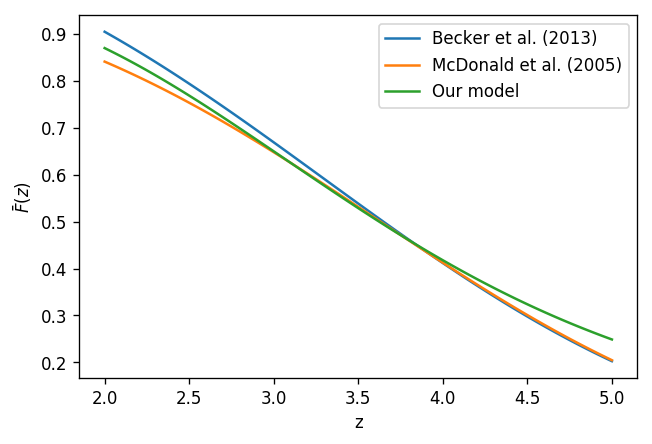

In [7]:
# specify redshift range
z=np.linspace(2.0,5.0,100)
# specify values for mean flux parameters
z_star=3
tau_star=-np.log(0.65)
n_tau=3.5
alpha_tau=-1.5
tau_eff=tau_effective(z,z_star,tau_star,n_tau,alpha_tau)
plot_mean_flux(z,model=np.exp(-tau_eff))

### Compute marginalized likelihood for every point in ($\Delta_p^2$,$n_p$) 

### Choose parameter space based on previous Lyman-$\alpha$ work

We will plot here the contours on ($\Delta_p^2$,$n_p$) from McDonald et al. (2005) and Chabanier et al. (2019)

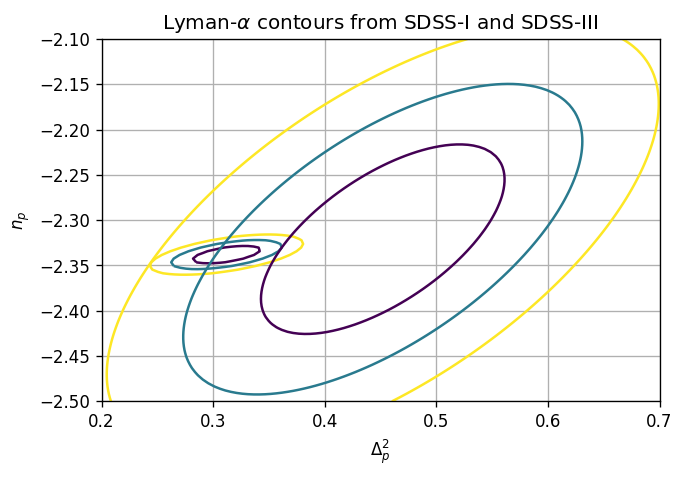

In [8]:
plt.figure()
# create grid (note j in number of elements, crazy python)
#DL2_fine_grid,np_fine_grid = np.mgrid[0.15:0.45:100j,-2.40:-2.28:100j]
DL2_fine_grid,np_fine_grid = np.mgrid[0.20:0.70:100j,-2.50:-2.10:100j]
chi2_fine_grid_2005=lya_results.gaussian_chi2_McDonald2005(np_fine_grid,DL2_fine_grid)
chi2_fine_grid_2019=lya_results.gaussian_chi2_Chabanier2019(np_fine_grid,DL2_fine_grid)

# we will plot the usual contours, equivalent to 1,2,3 sigma in 2D Gaussian
thresholds = [2.30,6.17,11.8]
plt.contour(DL2_fine_grid,np_fine_grid,chi2_fine_grid_2019,thresholds,label='Chabanier et al. (2019)')
plt.contour(DL2_fine_grid,np_fine_grid,chi2_fine_grid_2005,thresholds,label='McDonald et al. (2005)')

plt.title(r'Lyman-$\alpha$ contours from SDSS-I and SDSS-III')
plt.xlabel(r'$\Delta_p^2$')
plt.ylabel(r'$n_p$')
plt.grid() 